# Multi-Layer Perceptron
---
TUTURIAL: [Multi-Layer Perceptron, MNIST](https://www.kaggle.com/code/mishra1993/pytorch-multi-layer-perceptron-mnist/notebook) by Digit Recognizer

Purpose of this notebook is to provide me with training and understanding of MLP, Torch for HW2. In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

In [1]:
# import libraries
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from data_loader import TrainMNIST, TestMNIST

/var/folders/fz/zn5r8vq12nv5p23dtlr15sk40000gn/T/ipykernel_62583/904061888.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Pipeline

1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

# Load and visualize the data

In [2]:
train_data = TrainMNIST('../datasets/digit-recognizer/train.csv',  transform=transforms.ToTensor())
test_data = TestMNIST('../datasets/digit-recognizer/test.csv',  transform=transforms.ToTensor())

In [3]:
# as a positive integer will turn on multi-process data loading with the specified number of loader worker processes; otherwise, single-process data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


number_of_training_samples = len(train_data)
indices = list(range(number_of_training_samples))
# print("Before shuffle indices --", indices)
np.random.shuffle(indices)
# print("After shuffle indices --", indices)

split_idx = int(np.floor(valid_size * number_of_training_samples))
train_idx, valid_idx = indices[split_idx:], indices[:split_idx]
# why not 
# train_idx, valid_idx = indices[:split_idx], indices[split_idx:]

# sample elements randomly from a given list of indices, without replacement.
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
# sampler used to specify the sequence of indices/keys used in data loading. They represent iterable objects over the indices to dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
train_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

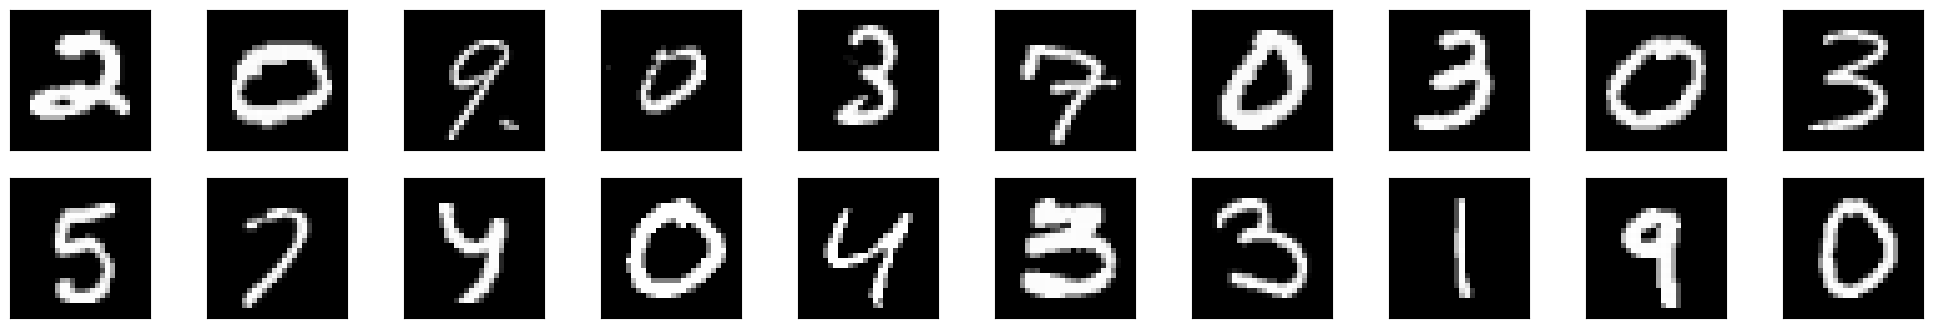

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    # ax.set_title(str(labels[idx].item()))